# Recommender Systems 2018/19

### Practice 8 - Hybrid recommenders


### The way to go to achieve the best recommendation quality

## A few info about hybrids


#### There are many different types of hibrids, in this practice we will see the following
* Linear combination of item-based models
* Linear combination of heterogeneous models
* User-wise discrimination


### Prerequisite: parameter tuning!

#### Let's have an example. In the course repo you will find a BayesianSearch object in the ParameterTuning folder. That is a simple wrapper of another library and its purpose is to provide a very simple way to tune some of the most common parameters. To run heavy tuning on more complex problems or with more sofisiticated constraints you may refer to other libraries.

In [1]:
from urllib.request import urlretrieve
import zipfile, os

# If file exists, skip the download
data_file_path = "data/Movielens_10M/"
data_file_name = data_file_path + "movielens_10m.zip"

# If directory does not exist, create
if not os.path.exists(data_file_path):
    os.makedirs(data_file_path)

if not os.path.exists(data_file_name):
    urlretrieve ("http://files.grouplens.org/datasets/movielens/ml-10m.zip", data_file_name)

dataFile = zipfile.ZipFile(data_file_name)
URM_path = dataFile.extract("ml-10M100K/ratings.dat", path="data/Movielens_10M")
URM_file = open(URM_path, 'r')


def rowSplit (rowString):
    
    split = rowString.split("::")
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = float(split[2])
    split[3] = int(split[3])
    
    result = tuple(split)
    
    return result


URM_file.seek(0)
URM_tuples = []

for line in URM_file:
   URM_tuples.append(rowSplit (line))

userList, itemList, ratingList, timestampList = zip(*URM_tuples)

userList = list(userList)
itemList = list(itemList)
ratingList = list(ratingList)
timestampList = list(timestampList)

import scipy.sparse as sps

URM_all = sps.coo_matrix((ratingList, (userList, itemList)))
URM_all = URM_all.tocsr()



In [2]:
ICM_path = dataFile.extract("ml-10M100K/tags.dat", path = "data/Movielens_10M")
ICM_file = open(ICM_path, 'r')

def rowSplit (rowString):
    split = rowString.split("::")
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = str(split[2]) # tag is a string, not a float like the rating
    split[3] = int(split[3])
    
    result = tuple(split)
    
    return result

ICM_file.seek(0)
ICM_tuples = []

for line in ICM_file:
    ICM_tuples.append(rowSplit(line))
    
userList_icm, itemList_icm, tagList_icm, timestampList_icm = zip(*ICM_tuples)

userList_icm = list(userList_icm)
itemList_icm = list(itemList_icm)
tagList_icm = list(tagList_icm)
timestampList_icm = list(timestampList_icm)

userList_unique = list(set(userList_icm))
itemList_unique = list(set(itemList_icm))
tagList_unique = list(set(tagList_icm))

numUsers = len(userList_unique)
numItems = len(itemList_unique)
numTags = len(tagList_unique)


print ("Number of items\t {}, Number of users\t {}".format(numItems, numUsers))
print ("Number of tags\t {}, Number of item-tag tuples {}".format(numTags, len(tagList_icm)))

print("\nData example:")
print(userList_icm[0:10])
print(itemList_icm[0:10])
print(tagList_icm[0:10])


from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(tagList_icm)

tagList_icm = le.transform(tagList_icm)

import numpy as np

ones = np.ones(len(tagList_icm))

ICM_all = sps.coo_matrix((ones, (itemList_icm, tagList_icm)), shape=(URM_all.shape[1], tagList_icm.max()+1))
ICM_all = ICM_all.tocsr()

Number of items	 7601, Number of users	 4009
Number of tags	 16529, Number of item-tag tuples 95580

Data example:
[15, 20, 20, 20, 20, 20, 20, 20, 20, 20]
[4973, 1747, 1747, 2424, 2424, 2424, 2947, 2947, 3033, 3033]
['excellent!', 'politics', 'satire', 'chick flick 212', 'hanks', 'ryan', 'action', 'bond', 'spoof', 'star wars']


In [3]:

from Notebooks_utils.data_splitter import train_test_holdout

URM_train, URM_test = train_test_holdout(URM_all, train_perc = 0.8)
URM_train, URM_validation = train_test_holdout(URM_train, train_perc = 0.9)

### Step 1: Import the evaluator objects

In [4]:
from Base.Evaluation.Evaluator import EvaluatorHoldout

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[5])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[5, 10])


### Step 2: Create BayesianSearch object

In [5]:
from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from ParameterTuning.SearchBayesianSkopt import SearchBayesianSkopt


recommender_class = ItemKNNCFRecommender

parameterSearch = SearchBayesianSkopt(recommender_class,
                                 evaluator_validation=evaluator_validation,
                                 evaluator_test=evaluator_test)


### Step 3: Define parameters range

In [6]:
from ParameterTuning.SearchAbstractClass import SearchInputRecommenderArgs
from skopt.space import Real, Integer, Categorical

hyperparameters_range_dictionary = {}
hyperparameters_range_dictionary["topK"] = Integer(5, 1000)
hyperparameters_range_dictionary["shrink"] = Integer(0, 1000)
hyperparameters_range_dictionary["similarity"] = Categorical(["cosine"])
hyperparameters_range_dictionary["normalize"] = Categorical([True, False])
    
    
recommender_input_args = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS = [URM_train],
    CONSTRUCTOR_KEYWORD_ARGS = {},
    FIT_POSITIONAL_ARGS = [],
    FIT_KEYWORD_ARGS = {}
)


output_folder_path = "result_experiments/"

import os

# If directory does not exist, create
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)
    

### Step 4: Run!

In [7]:
n_cases = 2
metric_to_optimize = "MAP"

parameterSearch.search(recommender_input_args,
                       parameter_search_space = hyperparameters_range_dictionary,
                       n_cases = n_cases,
                       n_random_starts = 1,
                       save_model = "no",
                       output_folder_path = output_folder_path,
                       output_file_name_root = recommender_class.RECOMMENDER_NAME,
                       metric_to_optimize = metric_to_optimize
                      )

Iteration No: 1 started. Evaluating function at random point.
ItemKNNCFRecommender: URM Detected 1690 (2.36 %) cold users.
ItemKNNCFRecommender: URM Detected 54506 (83.68 %) cold items.
SearchBayesianSkopt: Testing config: {'topK': 372, 'shrink': 929, 'similarity': 'cosine', 'normalize': True}
Similarity column 65134 ( 100 % ), 2699.88 column/sec, elapsed time 0.40 min
EvaluatorHoldout: Processed 22001 ( 32.63% ) in 30.15 sec. Users per second: 730
EvaluatorHoldout: Processed 44001 ( 65.26% ) in 1.01 min. Users per second: 727
EvaluatorHoldout: Processed 67429 ( 100.00% ) in 1.51 min. Users per second: 747
SearchBayesianSkopt: New best config found. Config 0: {'topK': 372, 'shrink': 929, 'similarity': 'cosine', 'normalize': True} - results: ROC_AUC: 0.2609313, PRECISION: 0.1301576, PRECISION_RECALL_MIN_DEN: 0.1602975, RECALL: 0.1022471, MAP: 0.0936119, MRR: 0.2683685, NDCG: 0.1108220, F1: 0.1145264, HIT_RATE: 0.6507882, ARHR: 0.3219221, RMSE: 34.4535587, NOVELTY: 0.0007072, AVERAGE_POP

In [8]:
from Base.DataIO import DataIO

data_loader = DataIO(folder_path = output_folder_path)
search_metadata = data_loader.load_data(recommender_class.RECOMMENDER_NAME + "_metadata.zip")

In [9]:
search_metadata

{'algorithm_name_search': 'SearchBayesianSkopt',
 'algorithm_name_recommender': 'ItemKNNCFRecommender',
 'exception_list': [None, None],
 'hyperparameters_list': [{'topK': 372,
   'shrink': 929,
   'similarity': 'cosine',
   'normalize': True},
  {'topK': 1000, 'shrink': 0, 'similarity': 'cosine', 'normalize': False}],
 'hyperparameters_best': {'topK': 372,
  'shrink': 929,
  'similarity': 'cosine',
  'normalize': True},
 'hyperparameters_best_index': 0,
 'result_on_validation_list': [{'ROC_AUC': 0.26093125114317756,
   'PRECISION': 0.13015764730305202,
   'PRECISION_RECALL_MIN_DEN': 0.16029749810912466,
   'RECALL': 0.10224708339842922,
   'MAP': 0.09361191854477403,
   'MRR': 0.2683684566976887,
   'NDCG': 0.11082199702296687,
   'F1': 0.11452641070230742,
   'HIT_RATE': 0.6507882365154459,
   'ARHR': 0.3219220711168002,
   'RMSE': 34.45355866203858,
   'NOVELTY': 0.0007071978295684804,
   'AVERAGE_POPULARITY': 0.5401785066876993,
   'DIVERSITY_MEAN_INTER_LIST': 0.942810544974015,
  

In [10]:
best_parameters = search_metadata["hyperparameters_best"]
best_parameters

{'topK': 372, 'shrink': 929, 'similarity': 'cosine', 'normalize': True}

# Linear combination of item-based models

#### Let's use an ItemKNNCF with the parameters we just learned and a graph based model

In [11]:
itemKNNCF = ItemKNNCFRecommender(URM_train)
itemKNNCF.fit(**best_parameters)


from GraphBased.P3alphaRecommender import P3alphaRecommender

P3alpha = P3alphaRecommender(URM_train)
P3alpha.fit()

ItemKNNCFRecommender: URM Detected 1690 (2.36 %) cold users.
ItemKNNCFRecommender: URM Detected 54506 (83.68 %) cold items.
Similarity column 65134 ( 100 % ), 2705.91 column/sec, elapsed time 0.40 min
P3alphaRecommender: URM Detected 1690 (2.36 %) cold users.
P3alphaRecommender: URM Detected 54506 (83.68 %) cold items.
P3alphaRecommender: Processed 56000 ( 85.98% ) in 1.00 minutes. Rows per second: 932


In [12]:
itemKNNCF.W_sparse

<65134x65134 sparse matrix of type '<class 'numpy.float32'>'
	with 3944685 stored elements in Compressed Sparse Row format>

In [13]:
P3alpha.W_sparse

<65134x65134 sparse matrix of type '<class 'numpy.float32'>'
	with 189735 stored elements in Compressed Sparse Row format>

### We may define another Recommender which takes the two matrices as input as well as the weights

In [14]:
from Base.Recommender_utils import check_matrix, similarityMatrixTopK
from Base.BaseSimilarityMatrixRecommender import BaseItemSimilarityMatrixRecommender


class ItemKNNSimilarityHybridRecommender(BaseItemSimilarityMatrixRecommender):
    """ ItemKNNSimilarityHybridRecommender
    Hybrid of two similarities S = S1*alpha + S2*(1-alpha)

    """

    RECOMMENDER_NAME = "ItemKNNSimilarityHybridRecommender"


    def __init__(self, URM_train, Similarity_1, Similarity_2, sparse_weights=True):
        super(ItemKNNSimilarityHybridRecommender, self).__init__(URM_train)

        if Similarity_1.shape != Similarity_2.shape:
            raise ValueError("ItemKNNSimilarityHybridRecommender: similarities have different size, S1 is {}, S2 is {}".format(
                Similarity_1.shape, Similarity_2.shape
            ))

        # CSR is faster during evaluation
        self.Similarity_1 = check_matrix(Similarity_1.copy(), 'csr')
        self.Similarity_2 = check_matrix(Similarity_2.copy(), 'csr')


    def fit(self, topK=100, alpha = 0.5):

        self.topK = topK
        self.alpha = alpha

        W = self.Similarity_1*self.alpha + self.Similarity_2*(1-self.alpha)
        self.W_sparse = similarityMatrixTopK(W, k=self.topK).tocsr()
       

In [15]:
hybridrecommender = ItemKNNSimilarityHybridRecommender(URM_train, itemKNNCF.W_sparse, P3alpha.W_sparse)
hybridrecommender.fit(alpha = 0.5)

ItemKNNSimilarityHybridRecommender: URM Detected 1690 (2.36 %) cold users.
ItemKNNSimilarityHybridRecommender: URM Detected 54506 (83.68 %) cold items.


In [16]:
evaluator_validation.evaluateRecommender(hybridrecommender)

EvaluatorHoldout: Processed 26770 ( 39.70% ) in 30.00 sec. Users per second: 892
EvaluatorHoldout: Processed 53001 ( 78.60% ) in 1.00 min. Users per second: 883
EvaluatorHoldout: Processed 67429 ( 100.00% ) in 1.25 min. Users per second: 901


({5: {'ROC_AUC': 0.25844097742316596,
   'PRECISION': 0.12954960032029972,
   'PRECISION_RECALL_MIN_DEN': 0.15954287719923044,
   'RECALL': 0.10163474678155263,
   'MAP': 0.09262757863827155,
   'MRR': 0.2658418484628558,
   'NDCG': 0.10899962107978554,
   'F1': 0.11390685389616081,
   'HIT_RATE': 0.6477480016016848,
   'ARHR': 0.31891495746145165,
   'RMSE': 8.16615152196382,
   'NOVELTY': 0.0007180533267231117,
   'AVERAGE_POPULARITY': 0.5069946484560671,
   'DIVERSITY_MEAN_INTER_LIST': 0.9582758097443332,
   'DIVERSITY_HERFINDAHL': 0.9916523196234288,
   'COVERAGE_ITEM': 0.03082875303221052,
   'COVERAGE_USER': 0.9421668902302706,
   'DIVERSITY_GINI': 0.09231011428122307,
   'SHANNON_ENTROPY': 7.768622683668138}},
 'CUTOFF: 5 - ROC_AUC: 0.2584410, PRECISION: 0.1295496, PRECISION_RECALL_MIN_DEN: 0.1595429, RECALL: 0.1016347, MAP: 0.0926276, MRR: 0.2658418, NDCG: 0.1089996, F1: 0.1139069, HIT_RATE: 0.6477480, ARHR: 0.3189150, RMSE: 8.1661515, NOVELTY: 0.0007181, AVERAGE_POPULARITY: 0.

### In this case the alpha coefficient is too a parameter to be tuned

# Linear combination of predictions

#### In case of models with incompatible structure (e.g., ItemKNN with UserKNN or MF) you may ensemble the prediction values

In [17]:
from MatrixFactorization.PureSVDRecommender import PureSVDRecommender

pureSVD = PureSVDRecommender(URM_train)
pureSVD.fit()

user_id = 42



PureSVDRecommender: URM Detected 1690 (2.36 %) cold users.
PureSVDRecommender: URM Detected 54506 (83.68 %) cold items.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... Done!


In [18]:
item_scores = itemKNNCF._compute_item_score(user_id)
item_scores

array([[ 0.        , 17.968529  , 19.619734  , ...,  0.        ,
         0.        ,  0.18193749]], dtype=float32)

In [19]:
item_scores = pureSVD._compute_item_score(user_id)
item_scores

array([ 3.0278047e-06,  1.2563415e-01,  3.6480296e-01, ...,
        0.0000000e+00,  0.0000000e+00, -6.4620288e-04], dtype=float32)

In [20]:

class ItemKNNScoresHybridRecommender(BaseItemSimilarityMatrixRecommender):
    """ ItemKNNScoresHybridRecommender
    Hybrid of two prediction scores R = R1*alpha + R2*(1-alpha)

    """

    RECOMMENDER_NAME = "ItemKNNScoresHybridRecommender"


    def __init__(self, URM_train, Recommender_1, Recommender_2):
        super(ItemKNNScoresHybridRecommender, self).__init__(URM_train)

        self.URM_train = check_matrix(URM_train.copy(), 'csr')
        self.Recommender_1 = Recommender_1
        self.Recommender_2 = Recommender_2
        
        
    def fit(self, alpha = 0.5):

        self.alpha = alpha      


    def _compute_item_score(self, user_id_array, items_to_compute):
        
        item_weights_1 = self.Recommender_1._compute_item_score(user_id_array)
        item_weights_2 = self.Recommender_2._compute_item_score(user_id_array)

        item_weights = item_weights_1*self.alpha + item_weights_2*(1-self.alpha)

        return item_weights


In [21]:
hybridrecommender = ItemKNNScoresHybridRecommender(URM_train, itemKNNCF, pureSVD)
hybridrecommender.fit(alpha = 0.5)

evaluator_validation.evaluateRecommender(hybridrecommender)

ItemKNNScoresHybridRecommender: URM Detected 1690 (2.36 %) cold users.
ItemKNNScoresHybridRecommender: URM Detected 54506 (83.68 %) cold items.
EvaluatorHoldout: Processed 16001 ( 23.73% ) in 30.15 sec. Users per second: 531
EvaluatorHoldout: Processed 33001 ( 48.94% ) in 1.01 min. Users per second: 544
EvaluatorHoldout: Processed 51001 ( 75.64% ) in 1.53 min. Users per second: 555
EvaluatorHoldout: Processed 67429 ( 100.00% ) in 1.98 min. Users per second: 566


({5: {'ROC_AUC': 0.26738618892958993,
   'PRECISION': 0.133963131590234,
   'PRECISION_RECALL_MIN_DEN': 0.16607171988314354,
   'RECALL': 0.10696381448850828,
   'MAP': 0.09742876045750272,
   'MRR': 0.2756170688180902,
   'NDCG': 0.11453224271367558,
   'F1': 0.11895064283124389,
   'HIT_RATE': 0.6698156579513266,
   'ARHR': 0.33171508796909205,
   'RMSE': 16.05654570915143,
   'NOVELTY': 0.0007128295927292377,
   'AVERAGE_POPULARITY': 0.5125136734271357,
   'DIVERSITY_MEAN_INTER_LIST': 0.9519882207818517,
   'DIVERSITY_HERFINDAHL': 0.9903948204804423,
   'COVERAGE_ITEM': 0.022415328399914024,
   'COVERAGE_USER': 0.9421668902302706,
   'DIVERSITY_GINI': 0.09530557703055702,
   'SHANNON_ENTROPY': 7.45076882842726}},
 'CUTOFF: 5 - ROC_AUC: 0.2673862, PRECISION: 0.1339631, PRECISION_RECALL_MIN_DEN: 0.1660717, RECALL: 0.1069638, MAP: 0.0974288, MRR: 0.2756171, NDCG: 0.1145322, F1: 0.1189506, HIT_RATE: 0.6698157, ARHR: 0.3317151, RMSE: 16.0565457, NOVELTY: 0.0007128, AVERAGE_POPULARITY: 0.

# User-wise hybrid

### Models do not have the same accuracy for different user types. Let's divide the users according to their profile length and then compare the recommendation quality we get from a CF model



In [22]:
URM_train = sps.csr_matrix(URM_train)

profile_length = np.ediff1d(URM_train.indptr)

### Let's select a few groups of 5% of the users with the least number of interactions

In [23]:
block_size = int(len(profile_length)*0.05)
block_size

3578

In [24]:
sorted_users = np.argsort(profile_length)

In [25]:
for group_id in range(0, 10):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, average p.len {:.2f}, min {}, max {}".format(group_id, 
        users_in_group_p_len.mean(), users_in_group_p_len.min(), users_in_group_p_len.max()))

Group 0, average p.len 6.75, min 0, max 14
Group 1, average p.len 15.49, min 14, max 17
Group 2, average p.len 17.78, min 17, max 19
Group 3, average p.len 20.11, min 19, max 21
Group 4, average p.len 22.86, min 21, max 24
Group 5, average p.len 26.06, min 24, max 28
Group 6, average p.len 29.79, min 28, max 32
Group 7, average p.len 34.05, min 32, max 36
Group 8, average p.len 38.96, min 36, max 42
Group 9, average p.len 44.80, min 42, max 48


### Now we plot the recommendation quality of TopPop and ItemKNNCF

In [26]:
from Base.NonPersonalizedRecommender import TopPop

topPop = TopPop(URM_train)
topPop.fit()


TopPopRecommender: URM Detected 1690 (2.36 %) cold users.
TopPopRecommender: URM Detected 54506 (83.68 %) cold items.


In [27]:
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender

recommender_class = ItemKNNCBFRecommender

parameterSearch = SearchBayesianSkopt(recommender_class,
                                 evaluator_validation=evaluator_validation,
                                 evaluator_test=evaluator_test)


In [28]:
hyperparameters_range_dictionary = {}
hyperparameters_range_dictionary["topK"] = Integer(5, 1000)
hyperparameters_range_dictionary["shrink"] = Integer(0, 1000)
hyperparameters_range_dictionary["similarity"] = Categorical(["cosine"])
hyperparameters_range_dictionary["normalize"] = Categorical([True, False])
    
    
recommender_input_args = SearchInputRecommenderArgs(
    CONSTRUCTOR_POSITIONAL_ARGS = [URM_train, ICM_all],
    CONSTRUCTOR_KEYWORD_ARGS = {},
    FIT_POSITIONAL_ARGS = [],
    FIT_KEYWORD_ARGS = {}
)


output_folder_path = "result_experiments/"

import os

# If directory does not exist, create
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)
    
    
    
n_cases = 2
metric_to_optimize = "MAP"

parameterSearch.search(recommender_input_args,
                       parameter_search_space = hyperparameters_range_dictionary,
                       n_cases = n_cases,
                       n_random_starts = 1,
                       save_model = "no",
                       output_folder_path = output_folder_path,
                       output_file_name_root = recommender_class.RECOMMENDER_NAME,
                       metric_to_optimize = metric_to_optimize
                      )

Iteration No: 1 started. Evaluating function at random point.
ItemKNNCBFRecommender: URM Detected 1690 (2.36 %) cold users.
ItemKNNCBFRecommender: URM Detected 54506 (83.68 %) cold items.
SearchBayesianSkopt: Testing config: {'topK': 614, 'shrink': 397, 'similarity': 'cosine', 'normalize': True}
Similarity column 65134 ( 100 % ), 4313.33 column/sec, elapsed time 0.25 min
EvaluatorHoldout: Processed 21001 ( 31.15% ) in 30.02 sec. Users per second: 699
EvaluatorHoldout: Processed 44001 ( 65.26% ) in 1.00 min. Users per second: 731
EvaluatorHoldout: Processed 67429 ( 100.00% ) in 1.49 min. Users per second: 753
SearchBayesianSkopt: New best config found. Config 0: {'topK': 614, 'shrink': 397, 'similarity': 'cosine', 'normalize': True} - results: ROC_AUC: 0.1440824, PRECISION: 0.0616115, PRECISION_RECALL_MIN_DEN: 0.0679977, RECALL: 0.0319340, MAP: 0.0405861, MRR: 0.1429237, NDCG: 0.0459257, F1: 0.0420652, HIT_RATE: 0.3080574, ARHR: 0.1620636, RMSE: 3.3472336, NOVELTY: 0.0007346, AVERAGE_PO

In [29]:
data_loader = DataIO(folder_path = output_folder_path)
search_metadata = data_loader.load_data(recommender_class.RECOMMENDER_NAME + "_metadata.zip")

best_parameters_ItemKNNCBF = search_metadata["hyperparameters_best"]
best_parameters_ItemKNNCBF

{'topK': 614, 'shrink': 397, 'similarity': 'cosine', 'normalize': True}

In [30]:
itemKNNCBF = ItemKNNCBFRecommender(URM_train, ICM_all)
itemKNNCBF.fit(**best_parameters_ItemKNNCBF)

ItemKNNCBFRecommender: URM Detected 1690 (2.36 %) cold users.
ItemKNNCBFRecommender: URM Detected 54506 (83.68 %) cold items.
Similarity column 65134 ( 100 % ), 4162.61 column/sec, elapsed time 0.26 min


In [31]:
URM_train

<71568x65134 sparse matrix of type '<class 'numpy.float64'>'
	with 7200036 stored elements in Compressed Sparse Row format>

In [32]:

MAP_itemKNNCF_per_group = []
MAP_itemKNNCBF_per_group = []
MAP_pureSVD_per_group = []
MAP_topPop_per_group = []
cutoff = 10

for group_id in range(0, 10):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, average p.len {:.2f}, min {}, max {}".format(group_id, 
        users_in_group_p_len.mean(), users_in_group_p_len.min(), users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert = True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users = users_not_in_group)
    
    
    results, _ = evaluator_test.evaluateRecommender(itemKNNCF)
    MAP_itemKNNCF_per_group.append(results[cutoff]["MAP"])
 
    results, _ = evaluator_test.evaluateRecommender(pureSVD)
    MAP_pureSVD_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_test.evaluateRecommender(itemKNNCBF)
    MAP_itemKNNCBF_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_test.evaluateRecommender(topPop)
    MAP_topPop_per_group.append(results[cutoff]["MAP"])

    
    

Group 0, average p.len 6.75, min 0, max 14
EvaluatorHoldout: Ignoring 67990 Users
EvaluatorHoldout: Processed 1888 ( 100.00% ) in 2.42 sec. Users per second: 781
EvaluatorHoldout: Processed 1888 ( 100.00% ) in 2.52 sec. Users per second: 750
EvaluatorHoldout: Processed 1888 ( 100.00% ) in 2.41 sec. Users per second: 785
EvaluatorHoldout: Processed 1888 ( 100.00% ) in 2.27 sec. Users per second: 830
Group 1, average p.len 15.49, min 14, max 17
EvaluatorHoldout: Ignoring 67990 Users
EvaluatorHoldout: Processed 3569 ( 100.00% ) in 4.32 sec. Users per second: 825
EvaluatorHoldout: Processed 3569 ( 100.00% ) in 4.46 sec. Users per second: 800
EvaluatorHoldout: Processed 3569 ( 100.00% ) in 4.27 sec. Users per second: 836
EvaluatorHoldout: Processed 3569 ( 100.00% ) in 3.95 sec. Users per second: 903
Group 2, average p.len 17.78, min 17, max 19
EvaluatorHoldout: Ignoring 67990 Users
EvaluatorHoldout: Processed 3560 ( 100.00% ) in 4.22 sec. Users per second: 843
EvaluatorHoldout: Processed 35

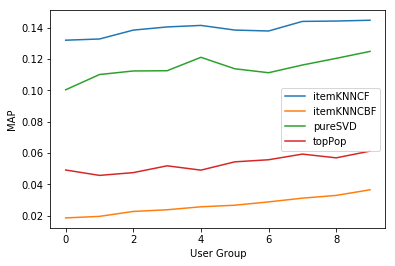

In [33]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(MAP_itemKNNCF_per_group, label="itemKNNCF")
pyplot.plot(MAP_itemKNNCBF_per_group, label="itemKNNCBF")
pyplot.plot(MAP_pureSVD_per_group, label="pureSVD")
pyplot.plot(MAP_topPop_per_group, label="topPop")
pyplot.ylabel('MAP')
pyplot.xlabel('User Group')
pyplot.legend()
pyplot.show()

### The recommendation quality of the three algorithms changes depending on the user profile length

## Tip:
### If an algorithm works best on average, it does not imply it will work best for ALL user types